In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, log_loss, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings, gc
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_feather("C:/Users/Krish Sanghvi/Desktop/GeorgeMason/CS584/Project/train_data.ftr")
df_train = df_train.groupby('customer_ID').tail(1).set_index('customer_ID')

df_test = pd.read_feather("C:/Users/Krish Sanghvi/Desktop/GeorgeMason/CS584/Project/test_data.ftr")
df_test = df_test.groupby('customer_ID').tail(1).set_index('customer_ID')

df_subm = pd.read_csv("C:/Users/Krish Sanghvi/Desktop/GeorgeMason/CS584/Project/sample_submission.csv")

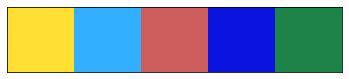

In [7]:
#Custom Color Palette 🎨
custom_colors = ["#ffe033","#33afff","#CD5C5C","","#1d8348"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)

In [8]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total number of rows (Train):', df_train_row_count)
print('Total number of columns (Train):', df_train_column_count)

Total number of rows (Train): 458913
Total number of columns (Train): 190


In [9]:
df_test_row_count, df_test_column_count=df_test.shape
print('Total number of rows (Test):', df_test_row_count)
print('Total number of columns (Test):', df_test_column_count)

Total number of rows (Test): 924621
Total number of columns (Test): 189


In [10]:
df_train['S_2'] = (df_train['S_2'] - pd.Timestamp('1970-01-01')).dt.days
df_test['S_2'] = (df_test['S_2'] - pd.Timestamp('1970-01-01')).dt.days

In [11]:
df_train.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,17603,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,NaN,...,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,17615,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,NaN,...,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,17602,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,NaN,...,NaN,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,17619,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,NaN,...,NaN,NaN,0.002705,0.006184,0.001899,NaN,0.008186,0.005558,0.002983,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,17620,0.872070,0.005573,0.007679,0.815918,0.001247,NaN,0.000231,0.005527,NaN,...,NaN,NaN,0.002974,0.004162,0.005764,NaN,0.008156,0.006943,0.000905,0


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 190 entries, S_2 to target
dtypes: category(11), float16(177), int64(2)
memory usage: 170.2+ MB


In [13]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [14]:
feat_Delinquency = [c for c in df_train.columns if c.startswith('D_')]
feat_Spend = [c for c in df_train.columns if c.startswith('S_')]
feat_Payment = [c for c in df_train.columns if c.startswith('P_')]
feat_Balance = [c for c in df_train.columns if c.startswith('B_')]
feat_Risk = [c for c in df_train.columns if c.startswith('R_')]
print(f'Total number of Delinquency variables: {len(feat_Delinquency)}')
print(f'Total number of Spend variables: {len(feat_Spend)}')
print(f'Total number of Payment variables: {len(feat_Payment)}')
print(f'Total number of Balance variables: {len(feat_Balance)}')
print(f'Total number of Risk variables: {len(feat_Risk)}')

Total number of Delinquency variables: 96
Total number of Spend variables: 22
Total number of Payment variables: 3
Total number of Balance variables: 40
Total number of Risk variables: 28


In [15]:
labels=['Delinquency', 'Spend','Payment','Balance','Risk']
values= [len(feat_Delinquency), len(feat_Spend),len(feat_Payment), len(feat_Balance),len(feat_Risk)]

In [19]:
fig_1 = go.Figure()
fig_1.add_trace(go.Pie(values = values,labels = labels,hole = 0.6, 
                     hoverinfo ='label+percent'))
fig_1.update_traces(textfont_size = 12, hoverinfo ='label+percent',textinfo ='label', 
                  showlegend = False,marker = dict(colors =["#e33907","#07e375"]),
                  title = dict(text = 'Feature Distribution'))  
fig_1.show()

In [20]:
df_train.isna().sum()

S_2            0
P_2         2969
D_39           0
B_1            0
B_2           31
           ...  
D_142     378598
D_143       2830
D_144          0
D_145       2830
target         0
Length: 190, dtype: int64

In [21]:
sum(df_train.isna().sum())

12995954

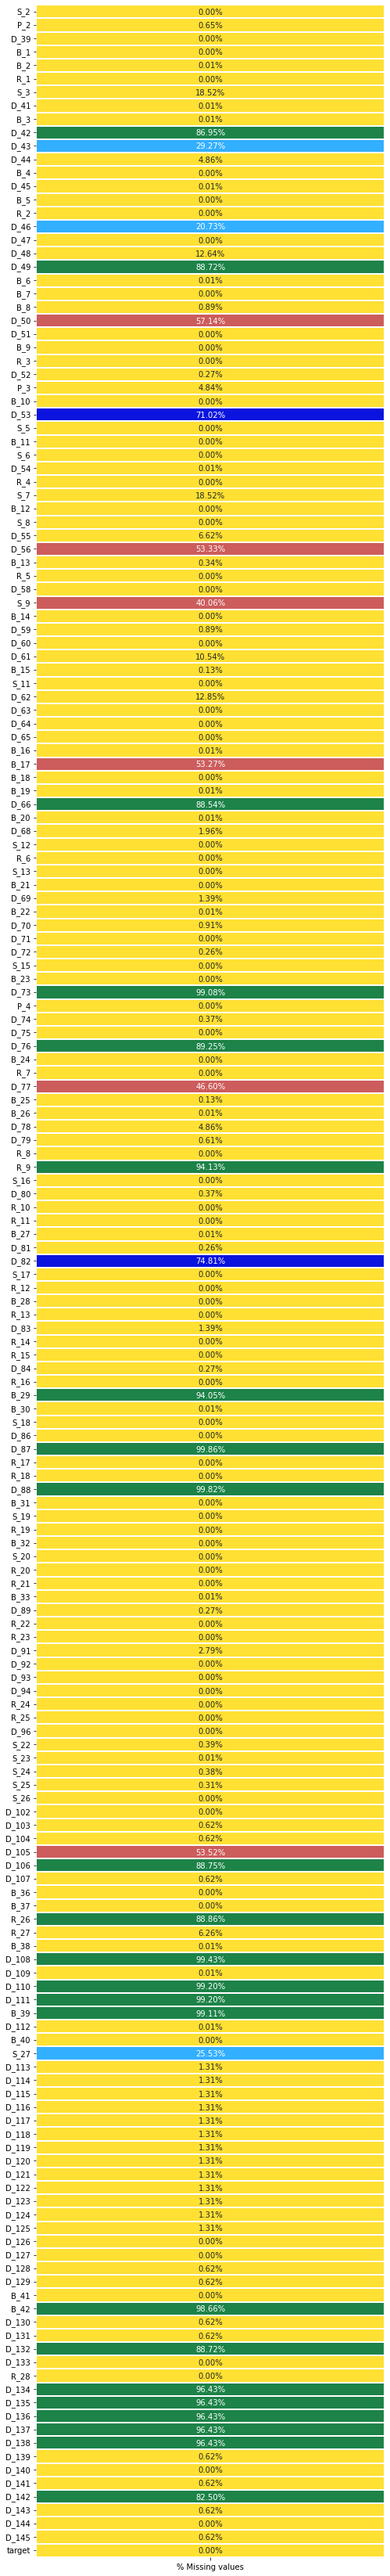

In [22]:
background_color = 'white'
missing = pd.DataFrame(columns = ['% Missing values'],data = df_train.isnull().sum()/len(df_train))
fig = plt.figure(figsize = (20, 60),facecolor=background_color)
gs = fig.add_gridspec(1, 2)
gs.update(wspace = 0.5, hspace = 0.5)
ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top","bottom","left"]:
    ax0.spines[s].set_visible(False)
sns.heatmap(missing,cbar = False,annot = True,fmt =".2%", linewidths = 2,cmap = custom_colors,vmax = 1, ax = ax0)
plt.show()

In [23]:
target_class = pd.DataFrame({'count': df_train.target.value_counts(),
                             'percentage': df_train['target'].value_counts() / df_train.shape[0] * 100
})

In [24]:
target_class 

,count,percentage
0,340085,74.106639
1,118828,25.893361


In [25]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Pie(values = target_class['count'],labels = target_class.index,hole = 0.6, 
                     hoverinfo ='label+percent'))
fig.update_traces(textfont_size = 12, hoverinfo ='label+percent',textinfo ='label', 
                  showlegend = False,marker = dict(colors =["#90cf8e","#ff70a6"]),
                  title = dict(text = 'Target Distribution'))  
fig.show()

In [27]:
stat_plot = df_train.reset_index().groupby('S_2')['customer_ID'].nunique().reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x = stat_plot['S_2'], y = stat_plot['customer_ID']))
fig.update_layout(title="Customer Statements", width = 800, height = 600,xaxis_title ='Statement Date',
                  paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgb(0,0,0,0)') 
fig['data'][0]['line']['color']="#0740e3"
fig.show()

In [28]:
gc.collect()

8234

In [29]:
del_cols = [c for c in df_train.columns if (c.startswith(('D','t'))) & (c not in cat_cols)]
df_del = df_train[del_cols]
spd_cols = [c for c in df_train.columns if (c.startswith(('S','t'))) & (c not in cat_cols)]
df_spd = df_train[spd_cols]
pay_cols = [c for c in df_train.columns if (c.startswith(('P','t'))) & (c not in cat_cols)]
df_pay = df_train[pay_cols]
bal_cols = [c for c in df_train.columns if (c.startswith(('B','t'))) & (c not in cat_cols)]
df_bal = df_train[bal_cols]
ris_cols = [c for c in df_train.columns if (c.startswith(('R','t'))) & (c not in cat_cols)]
df_ris = df_train[ris_cols]

In [ ]:
fig, axes = plt.subplots(29, 3, figsize = (35,150))
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(del_cols) - 1:
        sns.kdeplot(x = del_cols[i], hue='target', data = df_del, fill = True, ax = ax, palette =["#e63946","#8338ec"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
fig.suptitle('Distribution of Delinquency Variables', fontsize = 35, x = 0.5, y = 1)
plt.tight_layout()
plt.show()

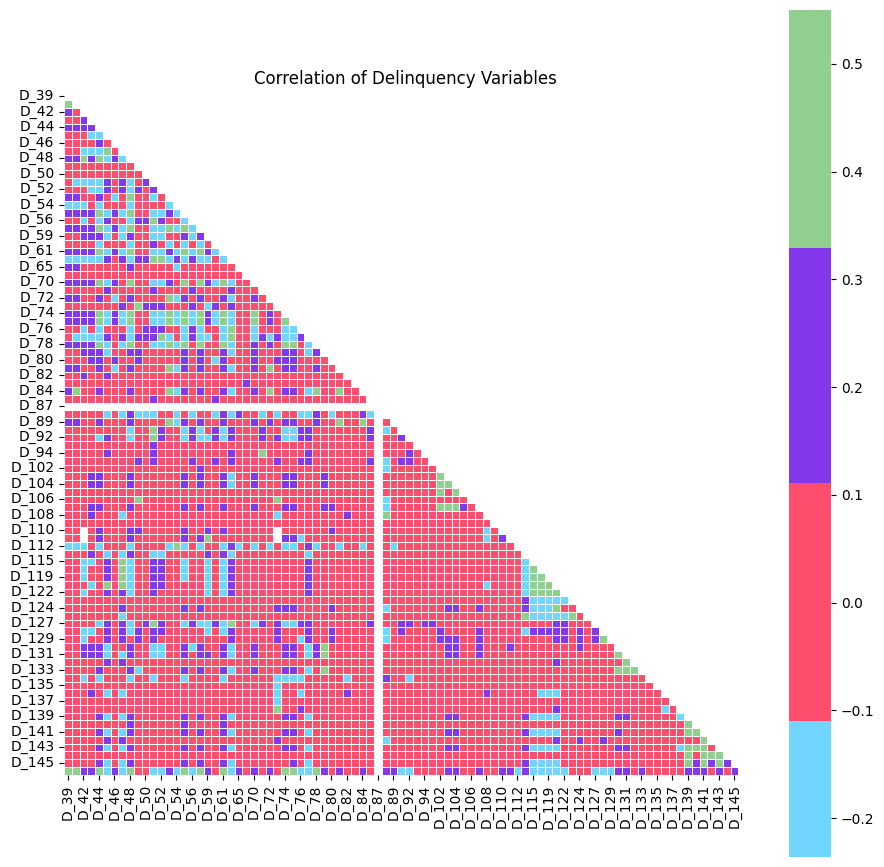

In [24]:
plt.figure(figsize =(11,11))
corr = df_del.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation of Delinquency Variables')
plt.show()

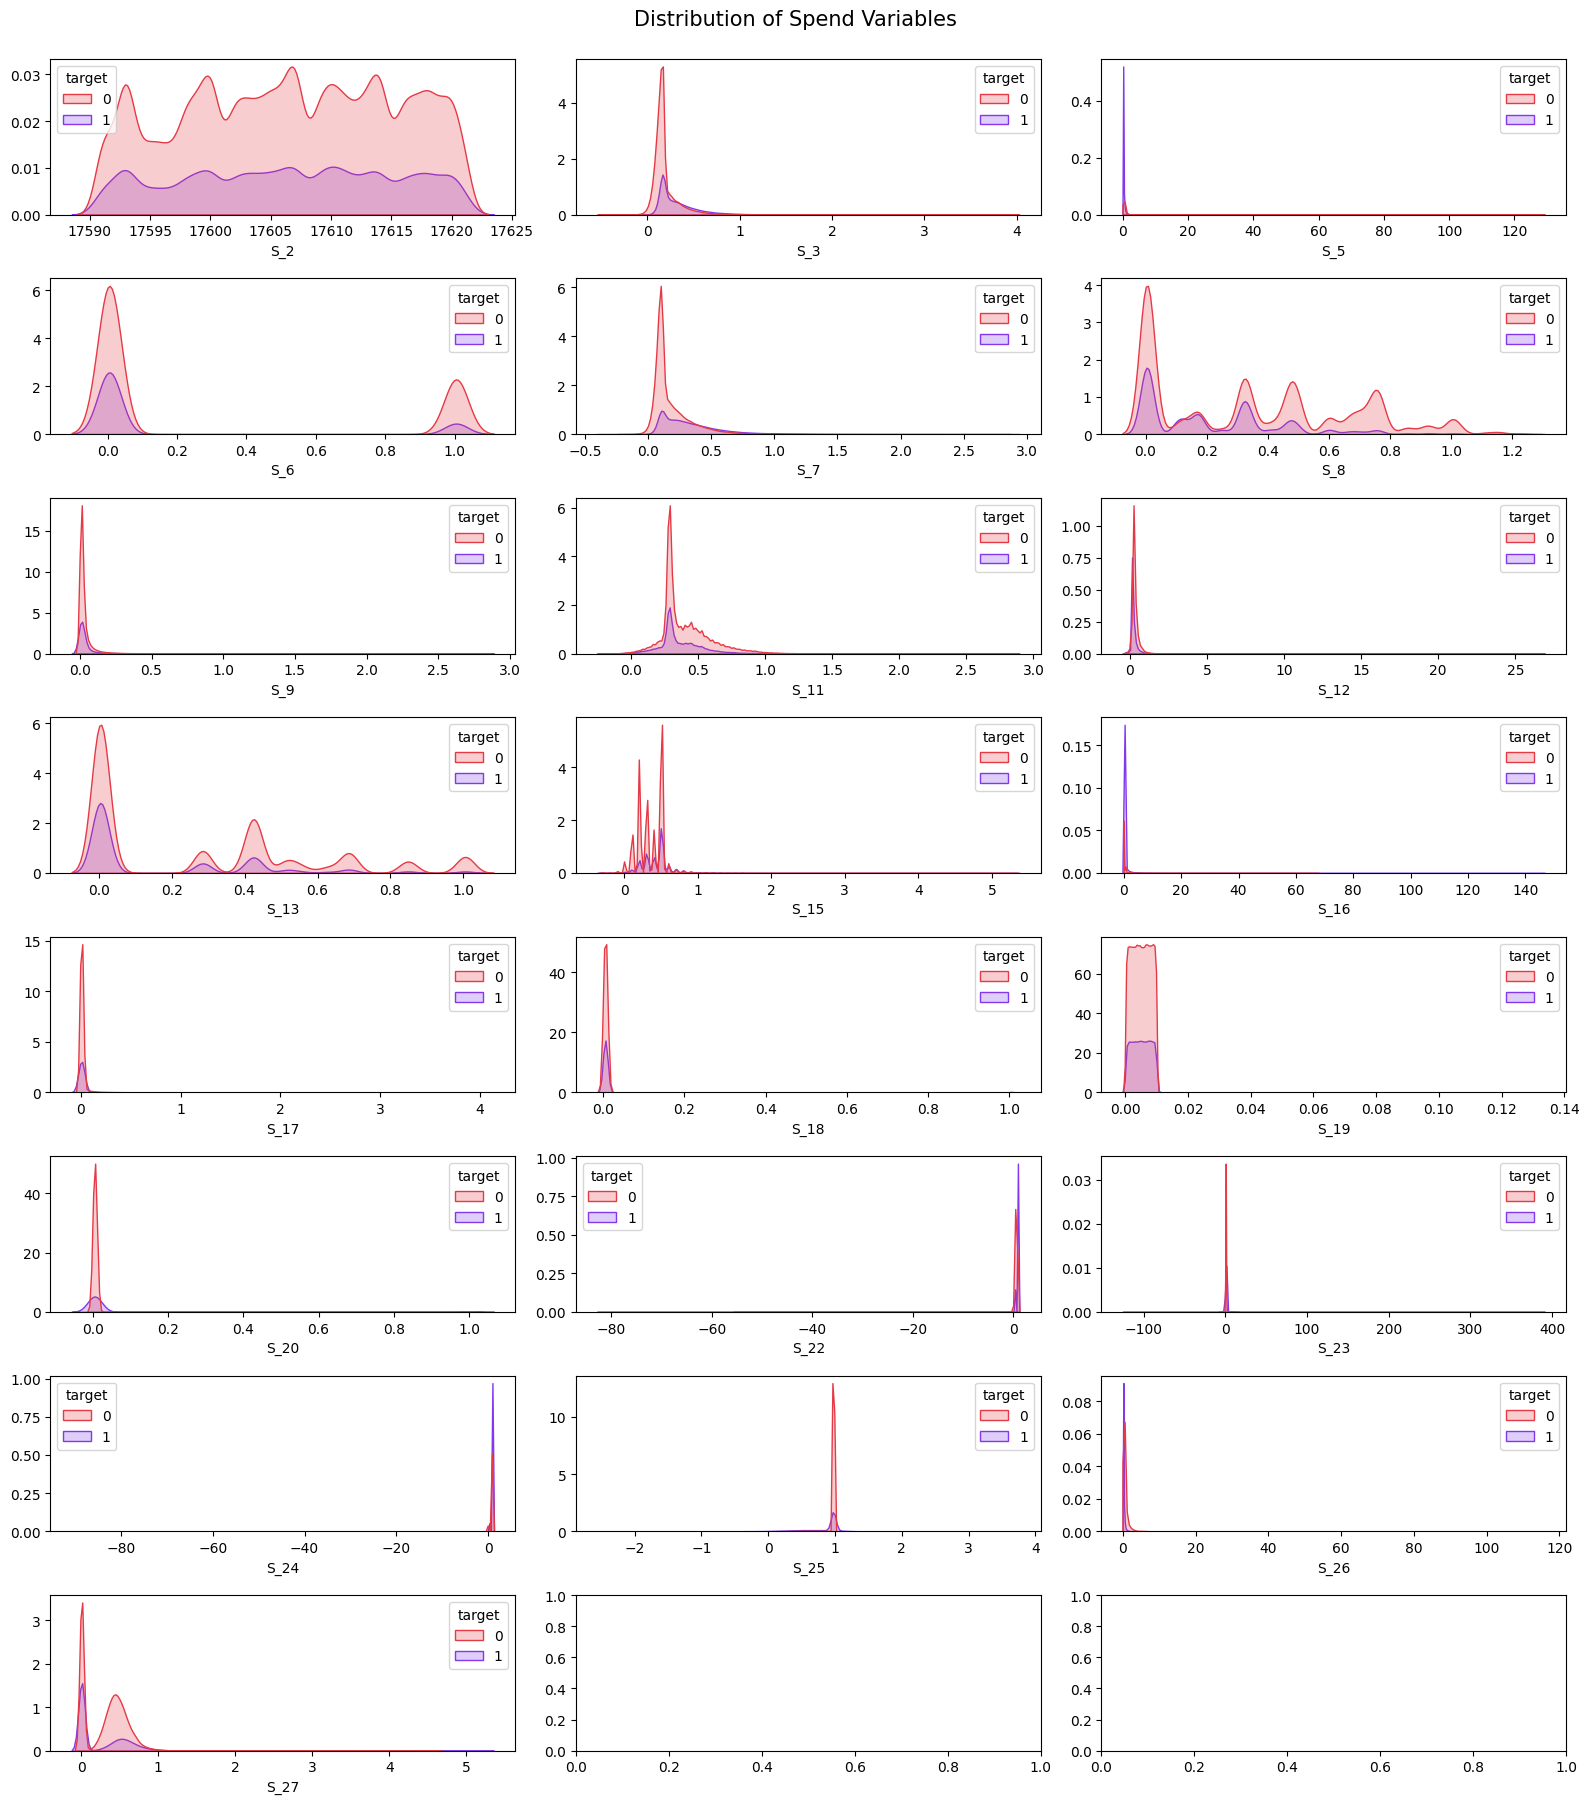

In [25]:
fig, axes = plt.subplots(8, 3, figsize = (16,18))
fig.suptitle('Distribution of Spend Variables', fontsize = 15, x = 0.5, y = 1)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(spd_cols) - 1:
        sns.kdeplot(x = spd_cols[i], hue ='target', data = df_spd, fill = True, ax = ax, palette =["#e63946","#8338ec"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [26]:
S_cols = [c for c in df_train.columns if (c.startswith(('S')))]
df_S = df_train[S_cols]

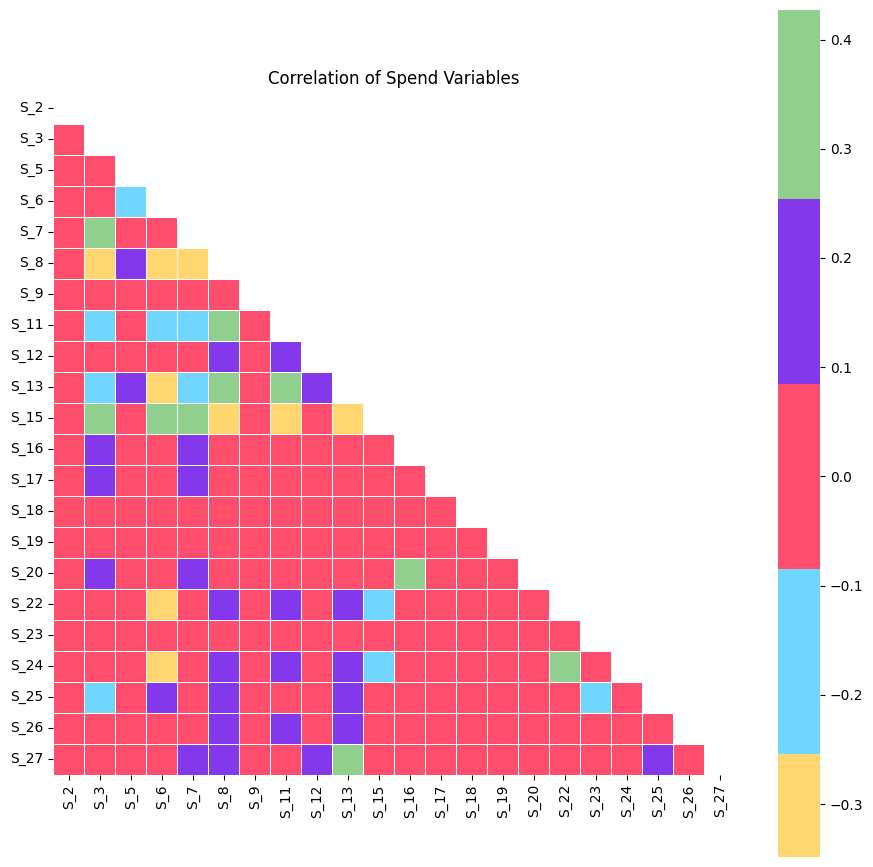

In [27]:
plt.figure(figsize = (11,11))
corr = df_S.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths = .6, cmap = custom_colors)
plt.title('Correlation of Spend Variables')
plt.show()

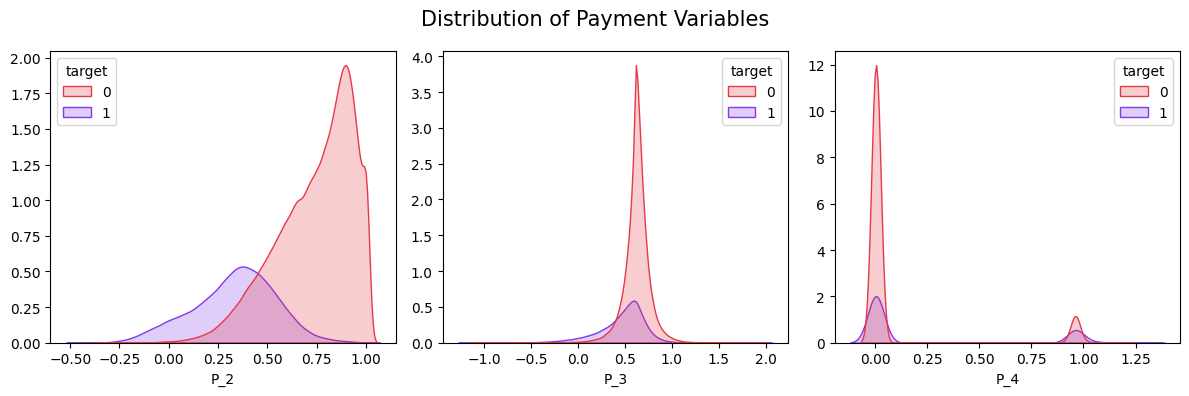

In [28]:
fig, axes = plt.subplots(1, 3, figsize = (12,4))
fig.suptitle('Distribution of Payment Variables',fontsize = 15)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(pay_cols) - 1:
        sns.kdeplot(x = pay_cols[i], hue ='target', data = df_pay, fill = True, ax = ax, palette =["#e63946","#8338ec"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [29]:
P_cols = [c for c in df_train.columns if (c.startswith(('P')))]
df_P = df_train[P_cols]

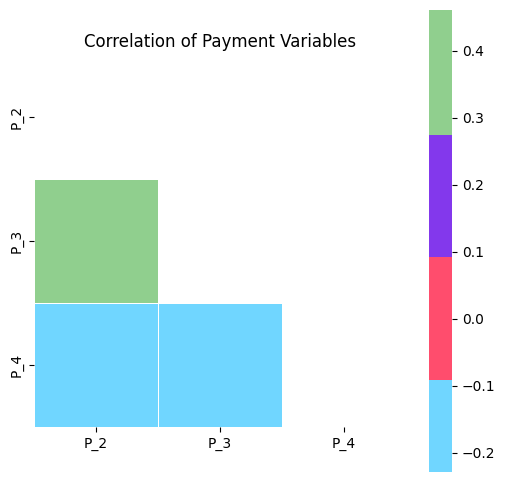

In [30]:
plt.figure(figsize = (6,6))
corr = df_P.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths = .6, cmap = custom_colors)
plt.title('Correlation of Payment Variables')
plt.show()

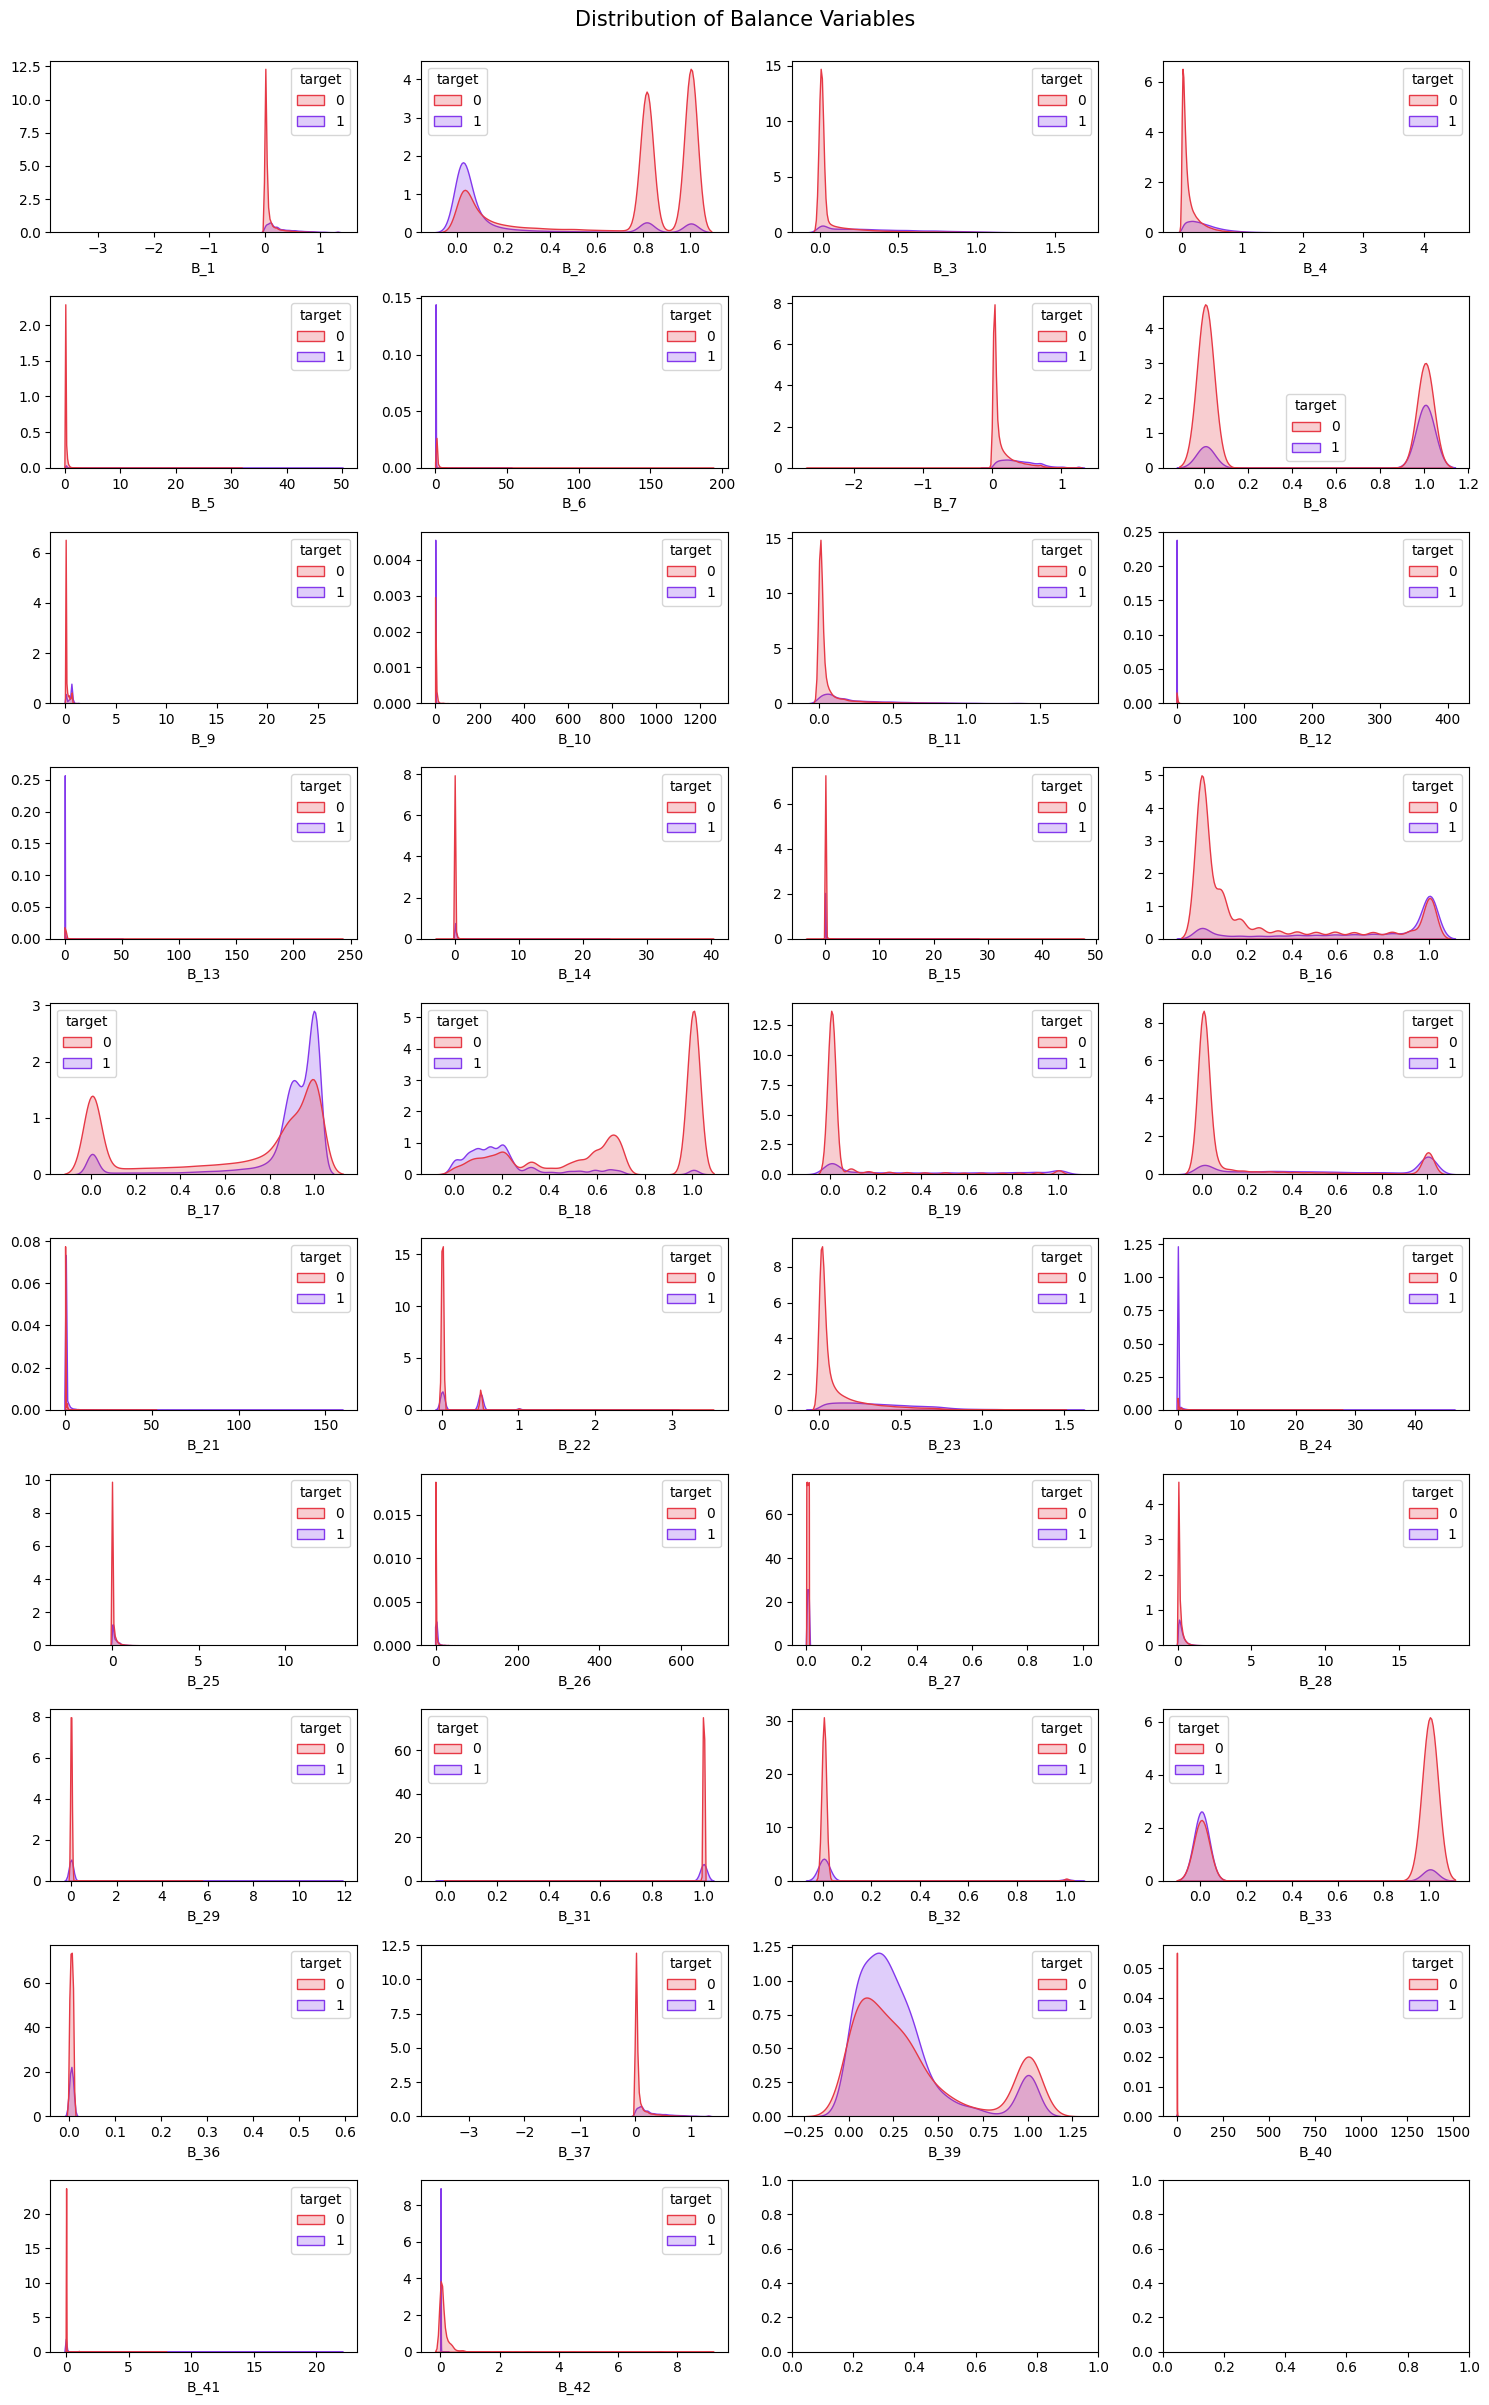

In [31]:
fig, axes = plt.subplots(10, 4, figsize = (15,24))
fig.suptitle('Distribution of Balance Variables',fontsize = 15, x = 0.5, y = 1)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(bal_cols) - 1:
        sns.kdeplot(x = bal_cols[i], hue ='target', data = df_bal, fill = True, ax = ax, palette =["#e63946","#8338ec"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [32]:
B_cols = [c for c in df_train.columns if (c.startswith(('B')))]
df_B = df_train[B_cols]

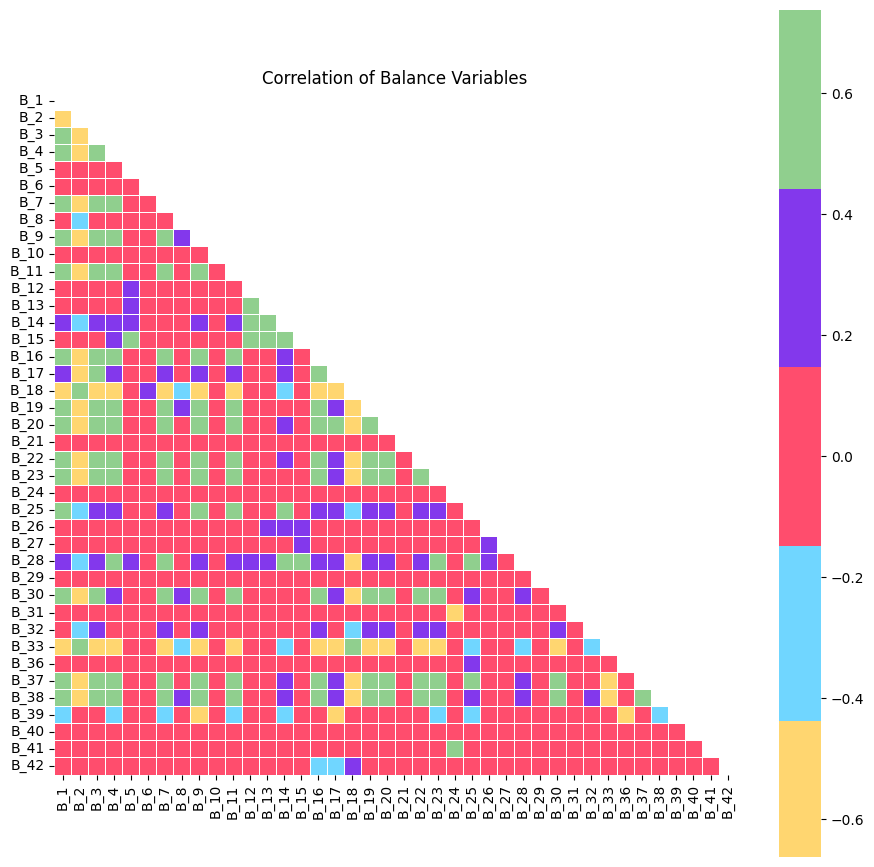

In [33]:
plt.figure(figsize = (11,11))
corr = df_B.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust=True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation of Balance Variables')
plt.show()

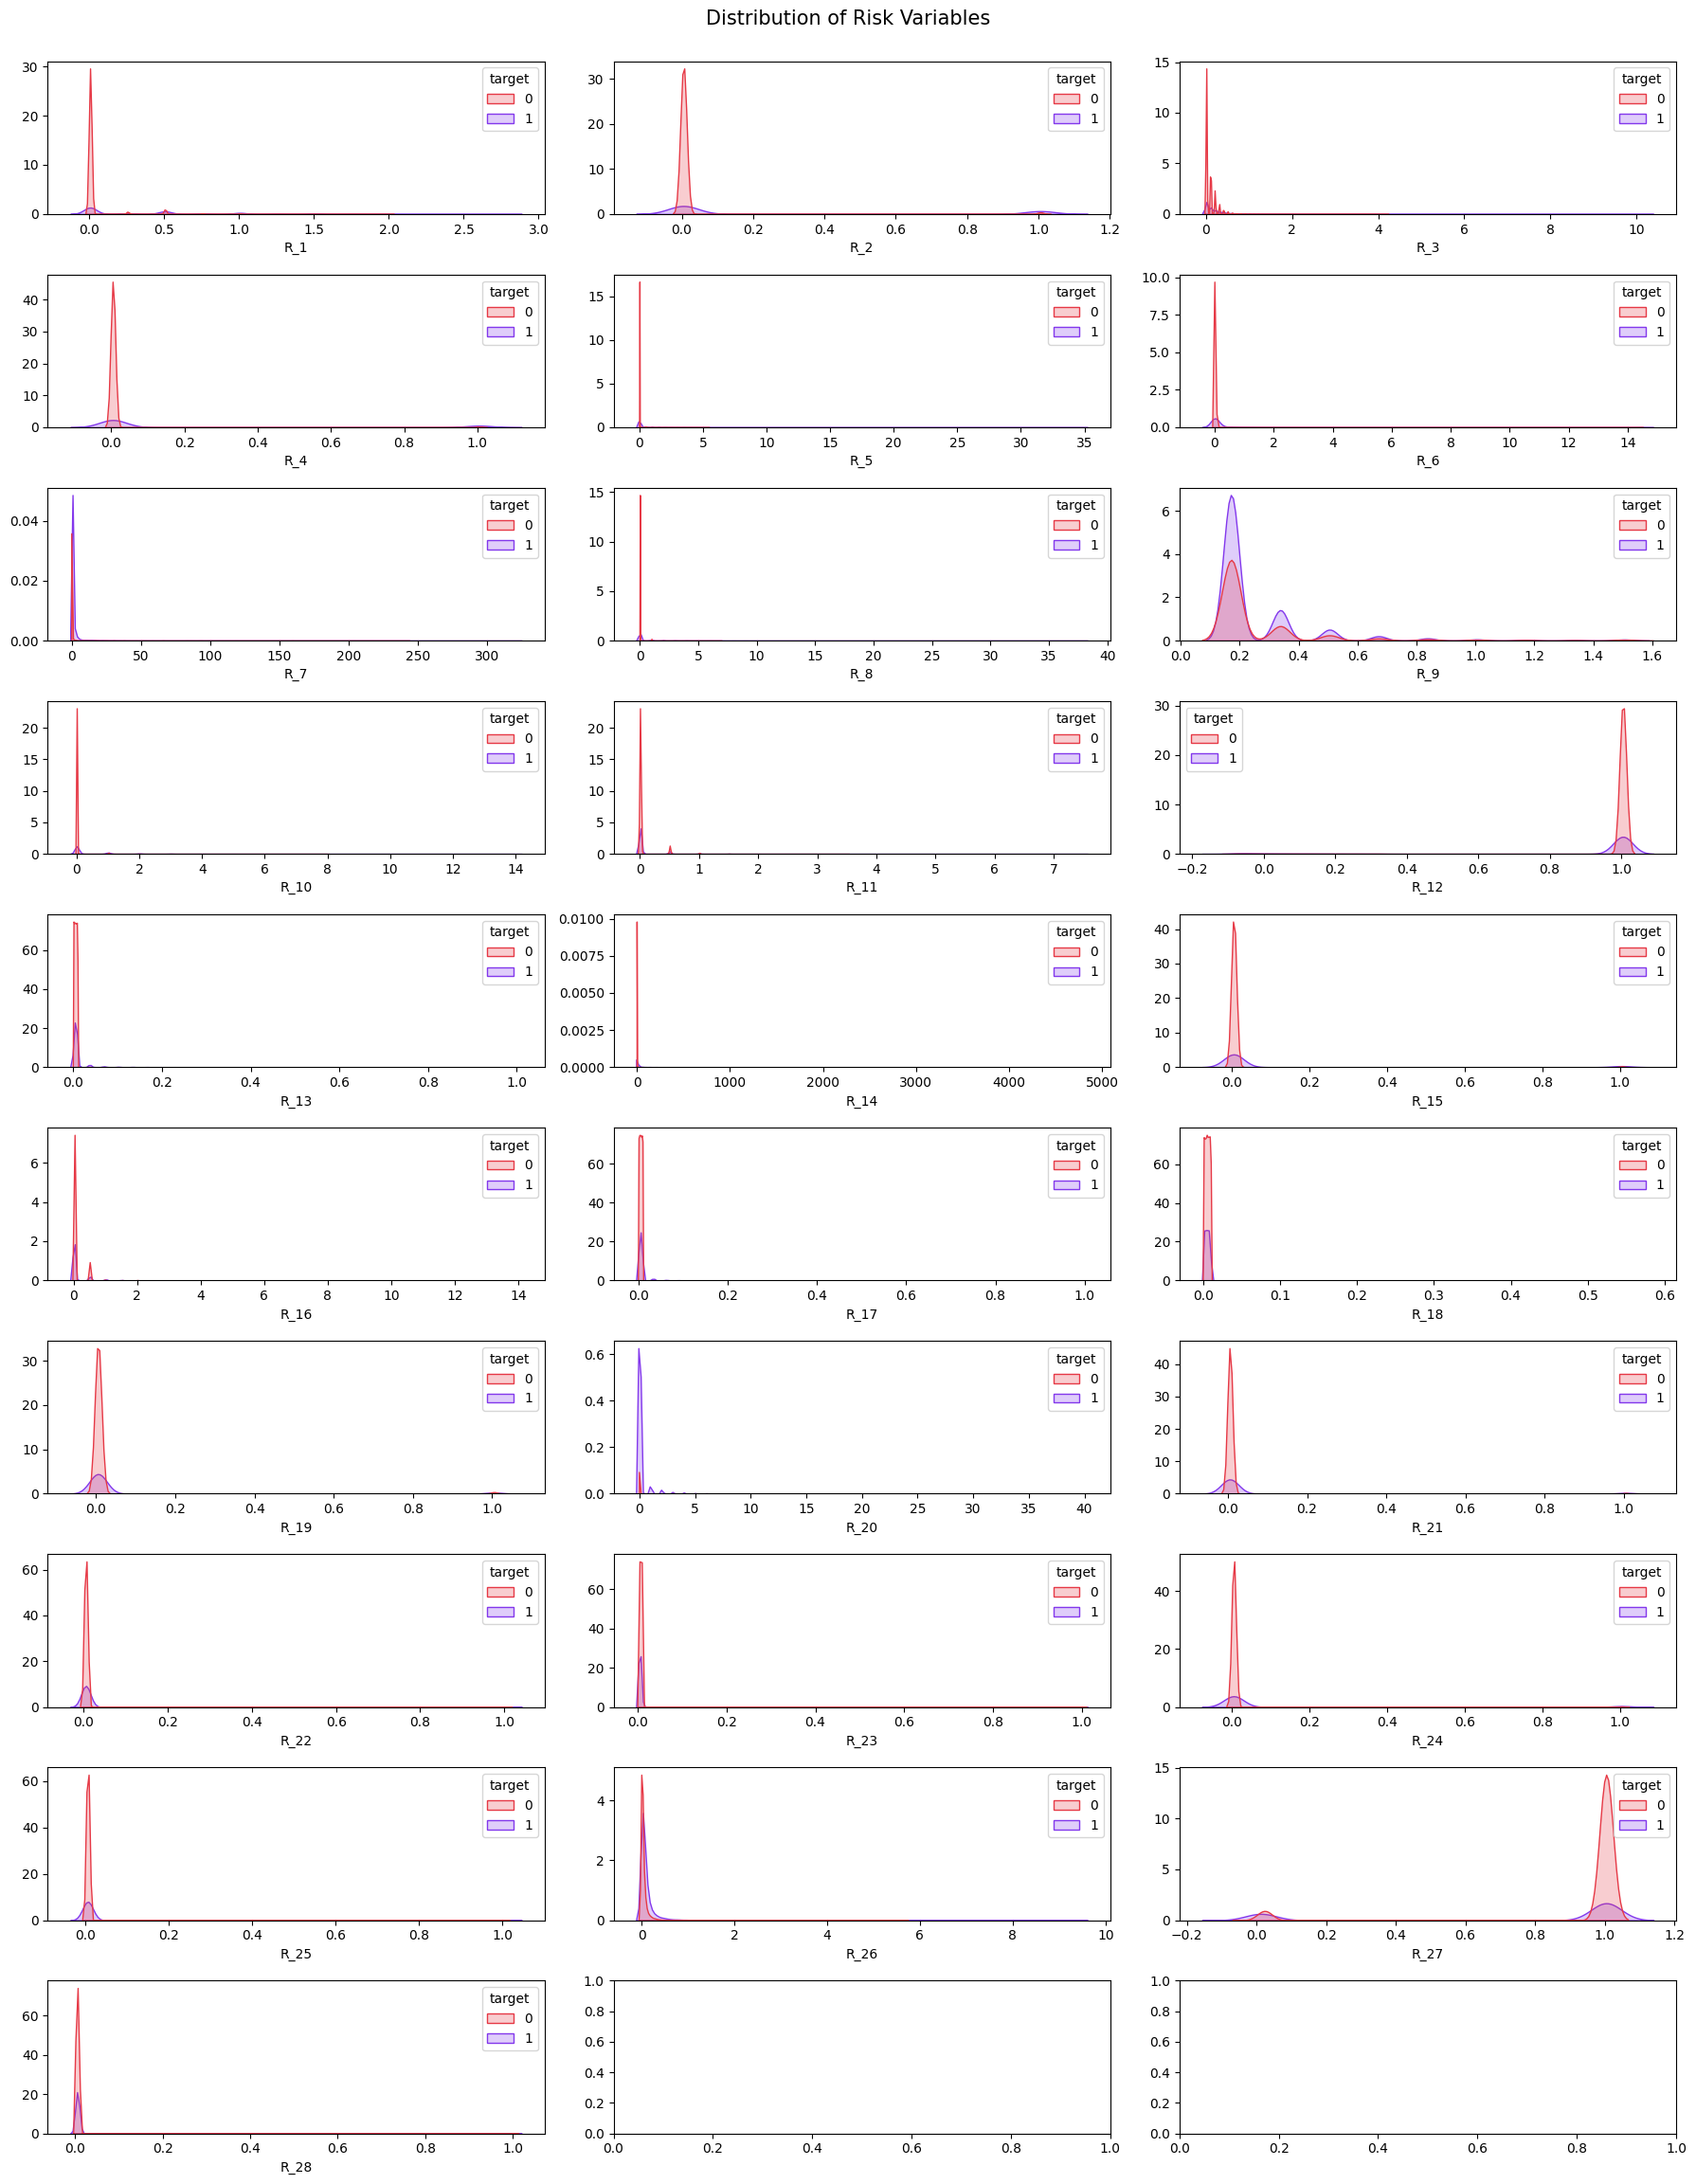

In [34]:
fig, axes = plt.subplots(10, 3, figsize = (18,23))
fig.suptitle('Distribution of Risk Variables',fontsize=15, x = 0.5, y = 1)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(ris_cols) - 1:
        sns.kdeplot(x = ris_cols[i], hue ='target', data = df_ris, fill = True, ax = ax, palette =["#e63946","#8338ec"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [35]:
R_cols = [c for c in df_train.columns if (c.startswith(('R')))]
df_R = df_train[R_cols]

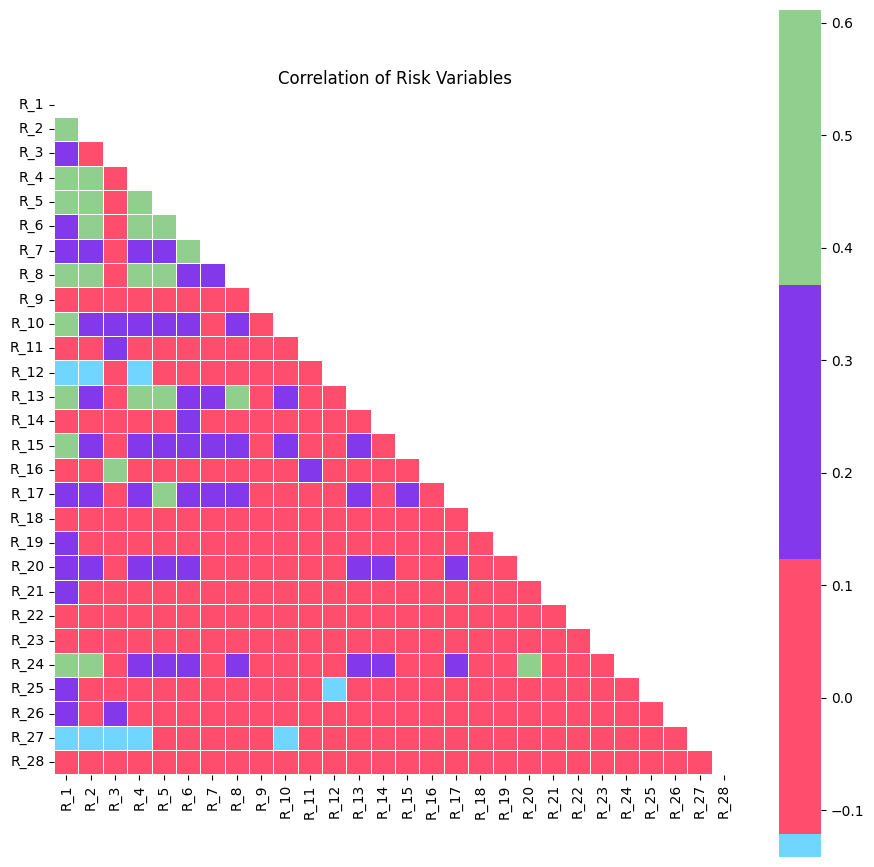

In [36]:
plt.figure(figsize=(11,11))
corr = df_R.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0, square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation of Risk Variables')
plt.show()

In [37]:
palette = cycle(["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"])

# Ensure the dataframe contains only numeric columns
df_numeric = df_train.select_dtypes(include=[np.number])  

# Compute correlation with the target column
targ = df_numeric.corrwith(df_train['target'], axis=0)

# Format the values for visualization
val = [str(round(v ,1) *100) + '%' for v in targ.values]
fig = go.Figure()
fig.add_trace(go.Bar(y=targ.index, x= targ.values, orientation='h',text = val, marker_color = next(palette)))
fig.update_layout(title = "Correlation of variables with Target",width = 750, height = 3500,
                  paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgb(0,0,0,0)')

In [38]:
gc.collect()

123236

In [39]:
X = df_train.drop('target', axis=1)
y = df_train['target']

In [40]:
lab_enc = LabelEncoder()
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for cat_feat in cat_cols:
    X[cat_feat] = lab_enc.fit_transform(X[cat_feat])
    df_test[cat_feat] = lab_enc.transform(df_test[cat_feat])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training : 

### XGBoost : 

[0]	validation_0-logloss:0.43641
[10]	validation_0-logloss:0.24491
[20]	validation_0-logloss:0.23367
[30]	validation_0-logloss:0.23088
[40]	validation_0-logloss:0.22961
[50]	validation_0-logloss:0.22904
[60]	validation_0-logloss:0.22894
[70]	validation_0-logloss:0.22911
[80]	validation_0-logloss:0.22914
[90]	validation_0-logloss:0.22943
[99]	validation_0-logloss:0.22969

XGBoost Performance Metrics:
F1 Score: 0.8001
Precision: 0.8000
Recall: 0.8001
Accuracy: 0.8974
AUC-ROC: 0.9569
Log Loss: 0.2297


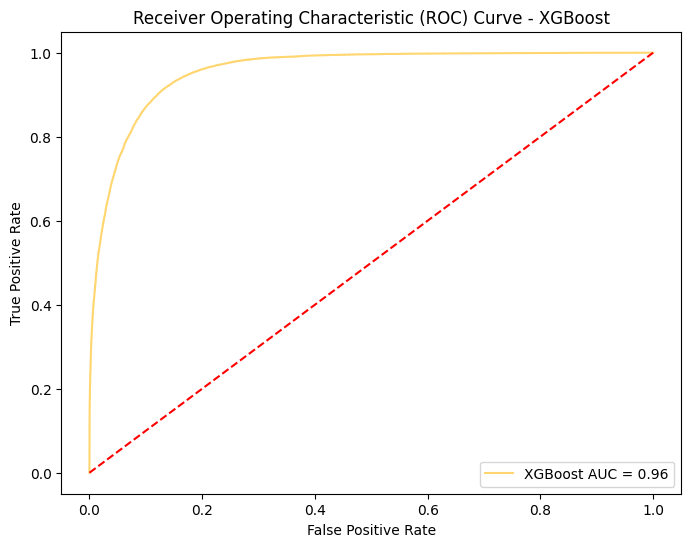

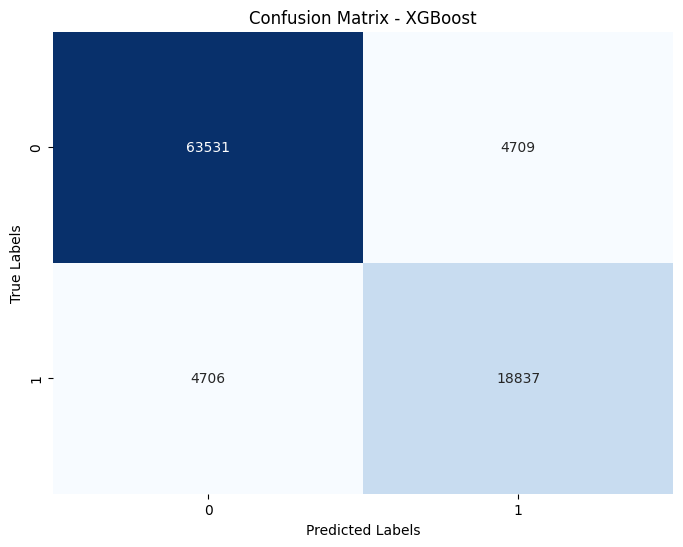

In [42]:
# Initialize XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train XGBoost model
xgb_model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              verbose=10)

# Get XGBoost predictions and probabilities
y_pred_class_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate XGBoost
print("\nXGBoost Performance Metrics:")
f1_xgb = f1_score(y_test, y_pred_class_xgb)
precision_xgb = precision_score(y_test, y_pred_class_xgb)
recall_xgb = recall_score(y_test, y_pred_class_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_class_xgb)
auc_roc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
log_loss_xgb = log_loss(y_test, y_pred_prob_xgb)

print(f'F1 Score: {f1_xgb:.4f}')
print(f'Precision: {precision_xgb:.4f}')
print(f'Recall: {recall_xgb:.4f}')
print(f'Accuracy: {accuracy_xgb:.4f}')
print(f'AUC-ROC: {auc_roc_xgb:.4f}')
print(f'Log Loss: {log_loss_xgb:.4f}')

# ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost AUC = {auc_roc_xgb:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Random classifier line
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_class_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Save predictions
df_subm["prediction_xgb"] = xgb_model.predict_proba(df_test)[:, 1]

### CatBoost : 

Learning rate set to 0.136276
0:	learn: 0.5453439	test: 0.5450507	best: 0.5450507 (0)	total: 498ms	remaining: 8m 17s
100:	learn: 0.2239797	test: 0.2270912	best: 0.2270912 (100)	total: 34.5s	remaining: 5m 6s
200:	learn: 0.2162582	test: 0.2238995	best: 0.2238995 (200)	total: 1m 8s	remaining: 4m 31s
300:	learn: 0.2109067	test: 0.2232124	best: 0.2232069 (299)	total: 1m 41s	remaining: 3m 55s
400:	learn: 0.2061745	test: 0.2228536	best: 0.2228387 (390)	total: 2m 15s	remaining: 3m 21s
500:	learn: 0.2018876	test: 0.2227814	best: 0.2227299 (485)	total: 2m 48s	remaining: 2m 47s
600:	learn: 0.1977675	test: 0.2227424	best: 0.2226705 (561)	total: 3m 21s	remaining: 2m 13s
700:	learn: 0.1937111	test: 0.2226958	best: 0.2226705 (561)	total: 3m 54s	remaining: 1m 40s
800:	learn: 0.1896447	test: 0.2228415	best: 0.2226705 (561)	total: 4m 28s	remaining: 1m 6s
900:	learn: 0.1858817	test: 0.2231003	best: 0.2226705 (561)	total: 5m 2s	remaining: 33.2s
999:	learn: 0.1822346	test: 0.2231936	best: 0.2226705 (561)	t

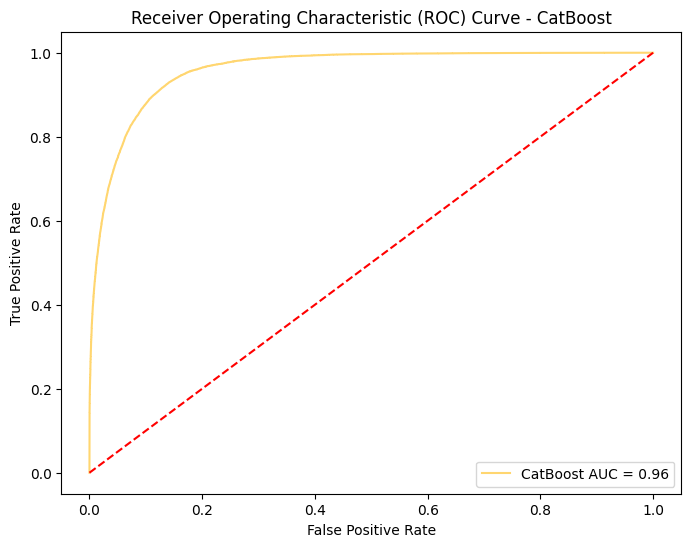

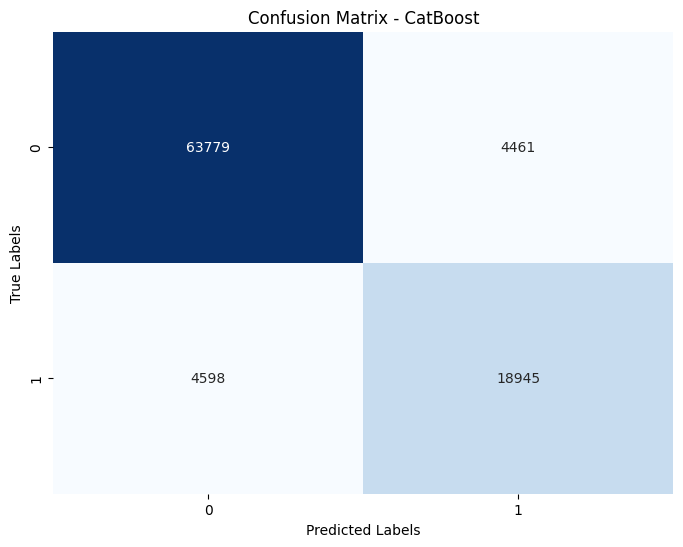

In [43]:
# Initialize CatBoost
catboost_model = CatBoostClassifier(iterations=1000, random_state=42, nan_mode='Min', task_type="CPU")

# Train CatBoost model
catboost_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=cat_cols, verbose=100)

# Get CatBoost predictions and probabilities
y_pred_class_catboost = catboost_model.predict(X_test)
y_pred_prob_catboost = catboost_model.predict_proba(X_test)[:, 1]

# Evaluate CatBoost
print("\nCatBoost Performance Metrics:")
f1_catboost = f1_score(y_test, y_pred_class_catboost)
precision_catboost = precision_score(y_test, y_pred_class_catboost)
recall_catboost = recall_score(y_test, y_pred_class_catboost)
accuracy_catboost = accuracy_score(y_test, y_pred_class_catboost)
auc_roc_catboost = roc_auc_score(y_test, y_pred_prob_catboost)
log_loss_catboost = log_loss(y_test, y_pred_prob_catboost)

print(f'F1 Score: {f1_catboost:.4f}')
print(f'Precision: {precision_catboost:.4f}')
print(f'Recall: {recall_catboost:.4f}')
print(f'Accuracy: {accuracy_catboost:.4f}')
print(f'AUC-ROC: {auc_roc_catboost:.4f}')
print(f'Log Loss: {log_loss_catboost:.4f}')

# ROC Curve for CatBoost
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_pred_prob_catboost)
plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, label=f'CatBoost AUC = {auc_roc_catboost:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Random classifier line
plt.title('Receiver Operating Characteristic (ROC) Curve - CatBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix for CatBoost
cm_catboost = confusion_matrix(y_test, y_pred_class_catboost)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_catboost, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - CatBoost')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Save predictions
df_subm["prediction_catboost"] = catboost_model.predict_proba(df_test)[:, 1]

### LightGBM :

[LightGBM] [Info] Number of positive: 95285, number of negative: 271845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44290
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259540 -> initscore=-1.048360
[LightGBM] [Info] Start training from score -1.048360

LightGBM Performance Metrics:
F1 Score: 0.8043
Precision: 0.8001
Recall: 0.8084
Accuracy: 0.8991
AUC-ROC: 0.9582
Log Loss: 0.2259


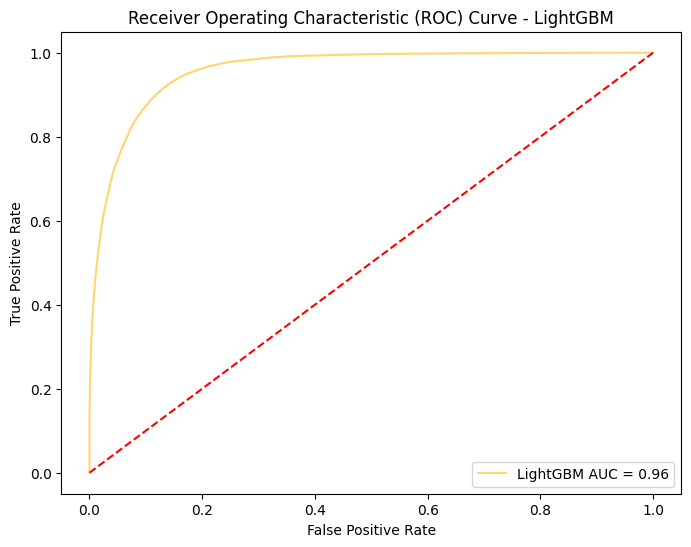

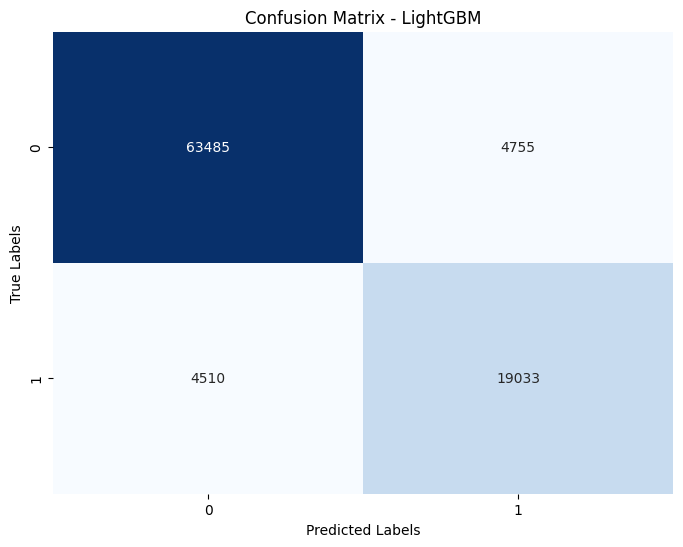

In [45]:
# Train LightGBM model
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Get predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_class = model.predict(X_test)

# Evaluate the model
print("\nLightGBM Performance Metrics:")
f1 = f1_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
accuracy = accuracy_score(y_test, y_pred_class)
auc_roc = roc_auc_score(y_test, y_pred_proba)
log_loss_value = log_loss(y_test, y_pred_proba)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')
print(f'Log Loss: {log_loss_value:.4f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Random classifier line
plt.title('Receiver Operating Characteristic (ROC) Curve - LightGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - LightGBM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [46]:
df_subm.to_csv('submission_combined.csv', index=False)
print(df_subm.head())

                                         customer_ID  prediction  \
0  00000469ba478561f23a92a868bd366de6f6527a684c9a...           0   
1  00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...           0   
2  0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...           0   
3  00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...           0   
4  00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...           0   

   prediction_xgb  prediction_catboost  
0        0.018373             0.013951  
1        0.000813             0.002487  
2        0.041022             0.054375  
3        0.246411             0.223357  
4        0.918382             0.831933  
